## Different perspective
1. PCA
2. manual
   - encode trustLevel
   - delete 'valuePerSecond', 'scannedLineItemsPerSecond', 'lineItemVoidsPerPosition'
   - generate no. item = totalScanTimeInSeconds * scannedLineItemsPerSecond
3. automatic generation

## Code for test
prepare different input dataset and test at 10-fold stratified cross validation set
1. train_data (raw data)
2. X_train_norm_enc data (normalized and encode)
3. X_train_manual (manual)
4. X_train_PCA (PCA)

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
from classifiers import *
from sklearn.metrics import confusion_matrix

## Original


In [20]:
train_data = pd.read_csv('data/train.csv', sep = '|')
test_data = pd.read_csv('data/test.csv', sep = '|')
print(f'Train set has {train_data.shape[0]} entries and {train_data.shape[1]} features')
print(f'Test set has {test_data.shape[0]} entries and {test_data.shape[1]} features')

y = train_data['fraud']
X = train_data.drop(columns=['fraud']).astype(float)
fit_minmax = MinMaxScaler()
X_encode = pd.get_dummies(X, columns=['trustLevel'], prefix='trustLevel')
X_train_norm_enc = pd.DataFrame(fit_minmax.fit_transform(X_encode), columns=X_encode.columns, index=X_encode.index)
print(X_train_norm_enc.shape)
X_test_encode = pd.get_dummies(test_data, columns=['trustLevel'], prefix='trustLevel')
X_test_norm_enc = pd.DataFrame(fit_minmax.transform(X_test_encode), columns=X_test_encode.columns, index=X_test_encode.index)


Train set has 1879 entries and 10 features
Test set has 498121 entries and 9 features


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(1879, 14)


## Manual


In [26]:
## delete correlate features
X_manual = X.assign(no_item = X.totalScanTimeInSeconds* X.scannedLineItemsPerSecond)\
                     .drop(columns=['valuePerSecond', 'scannedLineItemsPerSecond', 'lineItemVoidsPerPosition'])
fit_minmax = MinMaxScaler()
X_manual_encode = pd.get_dummies(X_manual, columns=['trustLevel'], prefix='trustLevel')
X_train_manual = pd.DataFrame(fit_minmax.fit_transform(X_manual_encode), columns=X_manual_encode.columns, index=X_manual_encode.index)
print(X_train_manual.shape)

X_test = test_data.assign(no_item = test_data.totalScanTimeInSeconds* test_data.scannedLineItemsPerSecond)\
                     .drop(columns=['valuePerSecond', 'scannedLineItemsPerSecond', 'lineItemVoidsPerPosition'])
X_test_encode = pd.get_dummies(X_test, columns=['trustLevel'], prefix='trustLevel')
X_test_manual = pd.DataFrame(fit_minmax.transform(X_test_encode), columns=X_test_encode.columns, index=X_test_encode.index)
print(X_test_manual.shape)


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(1879, 12)
(498121, 12)


In [15]:
def code_for_test(X,y):
    """
    test code with 10-fold stratified cross validation
    parameters
    X: trainset features after generation
    y: trainset y label
    """
    evaluate_classification(X, y)

In [16]:
code_for_test(X_train_norm_enc, y)

K Nerest Neighbors: test core = -710 
Linear SVM: test core = -520 
RBF SVM: test core = -610 
Logistic Regression: test core = -630 
Decision Tree: test core = -785 
Neural Net: test core = -470 
Random Forest: test core = -125 
AdaBoost: test core = -65 
XGBoost: test core = -60 


In [27]:
code_for_test(X_train_manual, y)

K Nerest Neighbors: test core = -65 
Linear SVM: test core = -520 
RBF SVM: test core = 225 
Logistic Regression: test core = 205 
Decision Tree: test core = -225 
Neural Net: test core = 180 
Random Forest: test core = 60 
AdaBoost: test core = 135 
XGBoost: test core = 80 


## PCA

In [28]:
from sklearn.decomposition import PCA 
pca = PCA(n_components = 'mle')
X_train_PCA = pca.fit_transform(X_train_manual)

In [29]:
print(X_train_PCA)

[[-0.13099807 -0.18135093 -0.59831003 ... -0.35507187  0.04499119
   0.02375011]
 [-0.16178626 -0.5190761   0.66883909 ...  0.08440497 -0.40951453
   0.29634846]
 [-0.165957   -0.60324774  0.65358775 ... -0.09587941  0.28145064
  -0.24725959]
 ...
 [-0.11464056 -0.13731552 -0.25649884 ... -0.5441087  -0.42823799
   0.10390581]
 [ 0.84510771  0.21068314  0.10823913 ... -0.33108723 -0.1483469
  -0.23213947]
 [-0.06398883 -0.15625338 -0.28303942 ... -0.22945717  0.15570135
   0.22435528]]


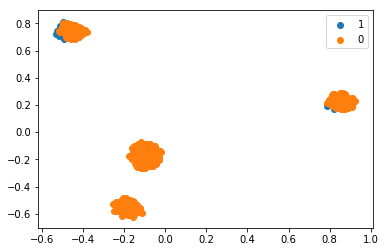

In [30]:
plt.scatter(X_train_PCA[y==1,0], X_train_PCA[y==1,1], label='1')
plt.scatter(X_train_PCA[y==0,0], X_train_PCA[y==0,1], label='0')
plt.legend()

In [31]:
code_for_test(X_train_PCA, y)

K Nerest Neighbors: test core = -65 
Linear SVM: test core = -520 
RBF SVM: test core = 225 
Logistic Regression: test core = 205 
Decision Tree: test core = -5 
Neural Net: test core = 190 
Random Forest: test core = 25 
AdaBoost: test core = 105 
XGBoost: test core = 115 


<h2> Define xgboost with cost sensitive </h2>

In [13]:
#!/usr/bin/python
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def logistic_obj(y_hat, dtrain, alpha=5, beta=25): # alpha for FN beta for FP
    y = dtrain.get_label()
    pred = 1. / (1. + np.exp(-y_hat))
    grad = pred * (beta + alpha*y - beta*y) - alpha*y  # alpha*(p-1)*y + beta*p*(1-y)
    hess = pred * (1 - pred) * (beta + alpha*y - beta*y)
    return grad, hess

def err_rate(pred, dtrain):
    y = dtrain.get_label()
    pred = 1. / (1. + np.exp(-pred))
    loss_fn = y*np.log(pred)
    loss_fp = (1.0 - y)*np.log(1.0 - pred)
    return 'error', np.sum(-(5*loss_fn+25*loss_fp))/len(y)




In [138]:
def cross_validate(X_train, X_test, y_train, y_test, depth, num_round):
    # load data
    d_train = xgb.DMatrix(X_train, label=y_train)
    d_val = xgb.DMatrix(X_test, label=y_test)
    # build model
    param = {'max_depth': depth, 'eta': 0.2, 'silent': 1, 'seed': 42, 'scale_pos_weight':1}
#     watchlist = [(d_val, 'eval'), (d_train, 'train')]
#     model_trn = xgb.train(param, d_train, num_round, watchlist, obj=logistic_obj, feval=err_rate)
    model_trn = xgb.train(param, d_train, num_round, obj=logistic_obj, feval=err_rate)
    # prediction
    pred = model_trn.predict(d_val) 
    pred = 1. / (1. + np.exp(-pred))
    return pred

In [130]:
def cv_cost(X,y, depth, rounds):
    cv = StratifiedKFold(n_splits=10, random_state=42)
    cost=0
    if type(X) == pd.DataFrame:
        X=X.values
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        pred = cross_validate(X_train, X_test, y_train, y_test, depth, rounds)
#         print(f' confusion matrix: cost({profit_scorer(y_test, pred>0.5)})\n {confusion_matrix(y_test, pred>0.5)}')
        cost += profit_scorer(y_test, pred>0.5)

    print(f'cost = {cost}')

In [145]:
cv_cost(X_train_norm_enc, y, 3 ,100)

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


cost = 70


In [140]:
cv_cost(X_train_manual, y, 3, 100)

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


cost = 180


In [141]:
cv_cost(X_train_PCA, y, 3, 100)

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


cost = 170
